In [180]:
from sqlalchemy import create_engine
from rent_scrapper import Arkadia_scrapper,push_newest_data
import pandas as pd
import matplotlib.pyplot as plt

In [181]:
#push_newest_data()

In [182]:
config = { 'user': "root",
            'password': "rootroot",
            'host': "localhost",
            'database': "apartments",
            'port': '3306'}

In [183]:
def create_url(user, password, host, database, port):
    return f"mysql://{user}:{password}@{host}:{port}/{database}"

pool = create_engine(url=create_url(**config),
                     pool_size=20, max_overflow=0
                     )
with pool.connect() as conn:
    sql = """SELECT m.room_number ,
m.apartment ,
date_update ,
price_floor ,
price_ceil ,
Avaliable_date ,
`Sq.Ft` ,
Floor_Plan ,
num_bedroom ,
num_bathroom
FROM apartments.prices p
	LEFT JOIN apartments.room_meta m
		ON p.apartment = m.apartment AND p.room_number = m.room_number;"""
    df = pd.read_sql(sql, conn)

In [184]:
df = df.merge(df.groupby(['Sq.Ft','date_update']).price_floor.mean().reset_index().rename({'price_floor':'price_mean_horizontal'},axis=1),
         on = ['Sq.Ft','date_update'])
df = df.merge( df.groupby('room_number').price_floor.mean().reset_index().rename({'price_floor':'price_mean_vertical'},axis=1),
               on = 'room_number')

In [186]:
df['deviation_from_cohort'] = df.eval('price_floor - price_mean_horizontal')
df['deviation_from_history'] = df.eval('price_floor - price_mean_vertical')
df['price_sqft'] = df.eval('price_floor / `Sq.Ft`')

In [187]:
# Analyze best deals
df.dropna(subset='price_floor').query('price_floor < price_mean_horizontal').sort_values(['room_number','date_update','price_mean_horizontal'])

,room_number,apartment,date_update,price_floor,price_ceil,Avaliable_date,Sq.Ft,Floor_Plan,num_bedroom,num_bathroom,price_mean_horizontal,price_mean_vertical,deviation_from_cohort,deviation_from_history,price_sqft
1556,#0701,Arkadia,2022-11-02 00:00:00,3740.0,4380.0,NaT,1168.0,2 Bed/2 Bath-01,2.0,2.0,3833.500,3739.016949,-93.500,0.983051,3.202055
1557,#0701,Arkadia,2022-11-03 12:52:26,3739.0,4379.0,NaT,1168.0,2 Bed/2 Bath-01,2.0,2.0,3832.500,3739.016949,-93.500,-0.016949,3.201199
1558,#0701,Arkadia,2022-11-03 13:00:27,3739.0,4379.0,NaT,1168.0,2 Bed/2 Bath-01,2.0,2.0,3832.500,3739.016949,-93.500,-0.016949,3.201199
1559,#0701,Arkadia,2022-11-03 13:40:33,3739.0,4379.0,NaT,1168.0,2 Bed/2 Bath-01,2.0,2.0,3832.500,3739.016949,-93.500,-0.016949,3.201199
1560,#0701,Arkadia,2022-11-03 14:00:27,3739.0,4379.0,NaT,1168.0,2 Bed/2 Bath-01,2.0,2.0,3832.500,3739.016949,-93.500,-0.016949,3.201199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,#2805,Arkadia,2022-11-04 04:00:23,2541.0,2930.0,2022-12-15,707.0,1 Bed/1 Bath-05,1.0,1.0,2595.375,2522.769231,-54.375,18.230769,3.594059
957,#2805,Arkadia,2022-11-04 05:00:23,2541.0,2930.0,2022-12-15,707.0,1 Bed/1 Bath-05,1.0,1.0,2595.375,2522.769231,-54.375,18.230769,3.594059
958,#2805,Arkadia,2022-11-04 06:00:24,2541.0,2930.0,2022-12-15,707.0,1 Bed/1 Bath-05,1.0,1.0,2595.375,2522.769231,-54.375,18.230769,3.594059
959,#2805,Arkadia,2022-11-04 07:00:24,2541.0,2930.0,2022-12-15,707.0,1 Bed/1 Bath-05,1.0,1.0,2595.375,2522.769231,-54.375,18.230769,3.594059


In [188]:
# Analyze best deals
df.dropna(subset='price_floor').query('price_floor < price_mean_vertical').sort_values(['room_number','date_update','deviation_from_history'])

,room_number,apartment,date_update,price_floor,price_ceil,Avaliable_date,Sq.Ft,Floor_Plan,num_bedroom,num_bathroom,price_mean_horizontal,price_mean_vertical,deviation_from_cohort,deviation_from_history,price_sqft
1557,#0701,Arkadia,2022-11-03 12:52:26,3739.0,4379.0,NaT,1168.0,2 Bed/2 Bath-01,2.0,2.0,3832.500000,3739.016949,-93.500000,-0.016949,3.201199
1558,#0701,Arkadia,2022-11-03 13:00:27,3739.0,4379.0,NaT,1168.0,2 Bed/2 Bath-01,2.0,2.0,3832.500000,3739.016949,-93.500000,-0.016949,3.201199
1559,#0701,Arkadia,2022-11-03 13:40:33,3739.0,4379.0,NaT,1168.0,2 Bed/2 Bath-01,2.0,2.0,3832.500000,3739.016949,-93.500000,-0.016949,3.201199
1560,#0701,Arkadia,2022-11-03 14:00:27,3739.0,4379.0,NaT,1168.0,2 Bed/2 Bath-01,2.0,2.0,3832.500000,3739.016949,-93.500000,-0.016949,3.201199
1561,#0701,Arkadia,2022-11-03 15:00:27,3739.0,4379.0,NaT,1168.0,2 Bed/2 Bath-01,2.0,2.0,3832.500000,3739.016949,-93.500000,-0.016949,3.201199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,#3212,Arkadia,2022-11-05 14:00:27,2547.0,3019.0,2023-01-07,799.0,1 Bed/1 Bath-12,1.0,1.0,2439.166667,2578.525424,107.833333,-31.525424,3.187735
1288,#3212,Arkadia,2022-11-05 15:00:28,2547.0,3019.0,2023-01-07,799.0,1 Bed/1 Bath-12,1.0,1.0,2439.166667,2578.525424,107.833333,-31.525424,3.187735
1289,#3212,Arkadia,2022-11-05 16:00:28,2547.0,3019.0,2023-01-07,799.0,1 Bed/1 Bath-12,1.0,1.0,2439.166667,2578.525424,107.833333,-31.525424,3.187735
1290,#3212,Arkadia,2022-11-05 17:00:28,2547.0,3019.0,2023-01-07,799.0,1 Bed/1 Bath-12,1.0,1.0,2439.166667,2578.525424,107.833333,-31.525424,3.187735


<AxesSubplot:>

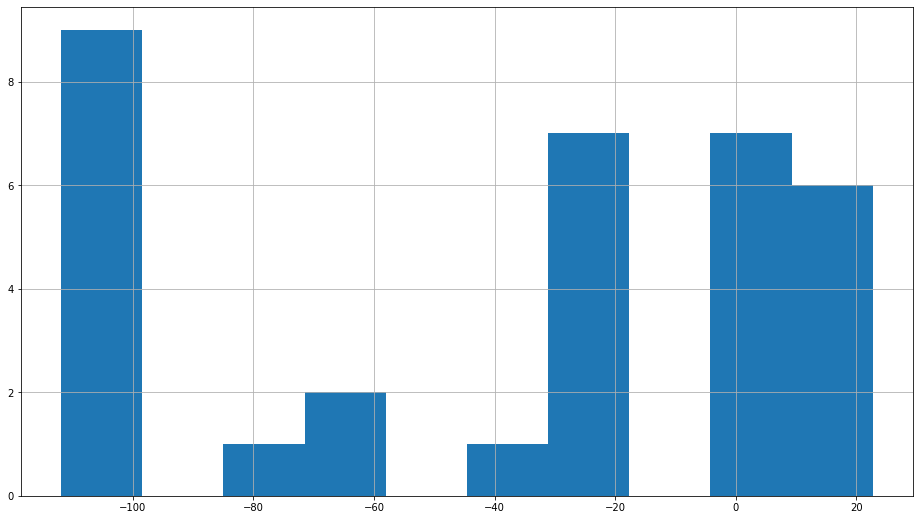

In [189]:
# Understand trend
df.query('date_update == "{}"'.format(df.date_update.max())).deviation_from_history.hist(figsize=(16,9))

In [190]:
def show_history(df_floor_group,title,by='price_floor'):
    legends = []
    plt.figure(figsize=(20,10))
    for group,df_group in df_floor_group.groupby('room_number'):
        legends.append(group+'|'+str(df_group['Sq.Ft'].to_list()[-1]))
        df_group = df_group.set_index('date_update')
        plt.plot(df_group.index, df_group[by])
    for group,df_group in df_floor_group.groupby('room_number'):
        #legends.append(group+'|'+str(df_group['Sq.Ft'].to_list()[-1]))
        df_group = df_group.set_index('date_update')
        plt.scatter(df_group.index, df_group[by])
    plt.legend(legends,loc='lower left', bbox_to_anchor=(1.01, 0., 0.5, 0.5))
    plt.title(title)
    plt.show()

In [191]:
df.query('date_update == "{}"'.format(df.date_update.max())).sort_values('price_sqft')

,room_number,apartment,date_update,price_floor,price_ceil,Avaliable_date,Sq.Ft,Floor_Plan,num_bedroom,num_bathroom,price_mean_horizontal,price_mean_vertical,deviation_from_cohort,deviation_from_history,price_sqft
1232,#2212,Arkadia,2022-11-05 18:18:03,2332.0,2745.0,2022-12-20,799.0,1 Bed/1 Bath-12,1.0,1.0,2439.166667,2360.745763,-107.166667,-28.745763,2.918648
1319,#1812,Arkadia,2022-11-05 18:18:03,2335.0,2661.0,2022-11-11,799.0,1 Bed/1 Bath-12,1.0,1.0,2439.166667,2335.000000,-104.166667,0.000000,2.922403
1496,#2113,Arkadia,2022-11-05 18:18:03,2505.0,2914.0,2022-12-11,847.0,1 Bed/1 Bath-13,1.0,1.0,2576.666667,2533.728814,-71.666667,-28.728814,2.957497
1114,#1712,Arkadia,2022-11-05 18:18:03,2402.0,2731.0,2022-11-06,799.0,1 Bed/1 Bath-12,1.0,1.0,2439.166667,2431.525424,-37.166667,-29.525424,3.006258
1378,#2313,Arkadia,2022-11-05 18:18:03,2592.0,2932.0,NaT,847.0,1 Bed/1 Bath-13,1.0,1.0,2576.666667,2621.525424,15.333333,-29.525424,3.060213
1437,#2713,Arkadia,2022-11-05 18:18:03,2633.0,2980.0,2022-11-21,847.0,1 Bed/1 Bath-13,1.0,1.0,2576.666667,2662.525424,56.333333,-29.525424,3.108619
1173,#2612,Arkadia,2022-11-05 18:18:03,2494.0,2831.0,2022-12-01,799.0,1 Bed/1 Bath-12,1.0,1.0,2439.166667,2523.542373,54.833333,-29.542373,3.121402
1055,#2912,Arkadia,2022-11-05 18:18:03,2525.0,2860.0,NaT,799.0,1 Bed/1 Bath-12,1.0,1.0,2439.166667,2554.542373,85.833333,-29.542373,3.160200
1291,#3212,Arkadia,2022-11-05 18:18:03,2547.0,3019.0,2023-01-07,799.0,1 Bed/1 Bath-12,1.0,1.0,2439.166667,2578.525424,107.833333,-31.525424,3.187735
1614,#0701,Arkadia,2022-11-05 18:18:03,3739.0,4379.0,NaT,1168.0,2 Bed/2 Bath-01,2.0,2.0,3832.500000,3739.016949,-93.500000,-0.016949,3.201199


C:\Users\18066\AppData\Local\Temp/ipykernel_13920/4289378579.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot.date_update = pd.DatetimeIndex(df_plot.date_update)


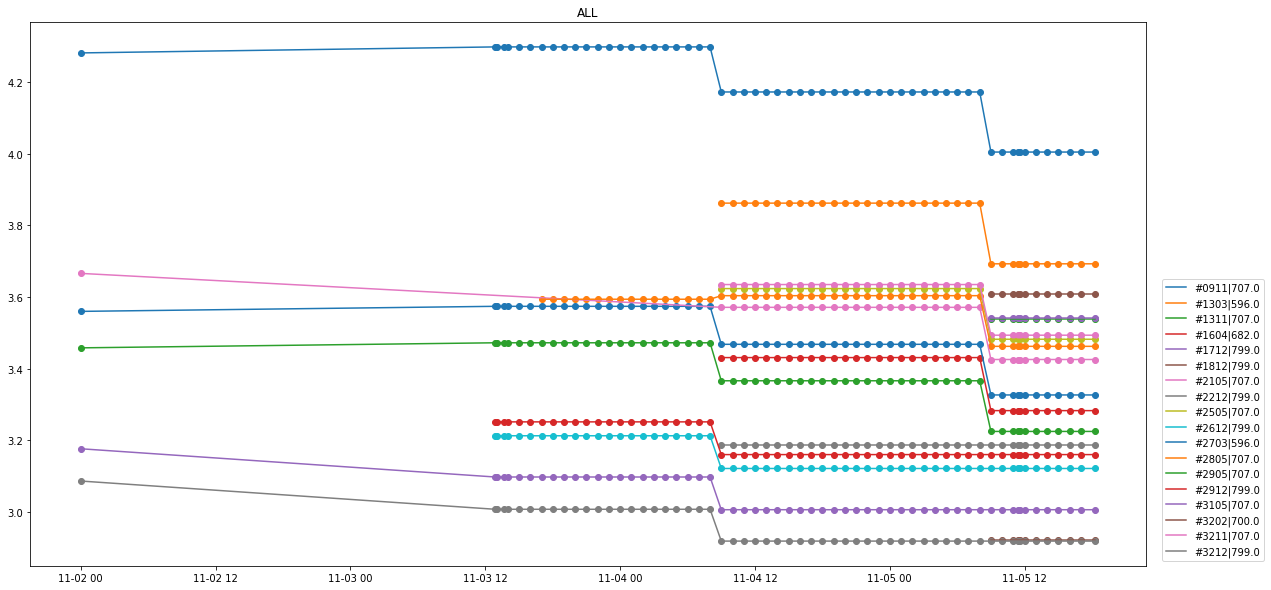

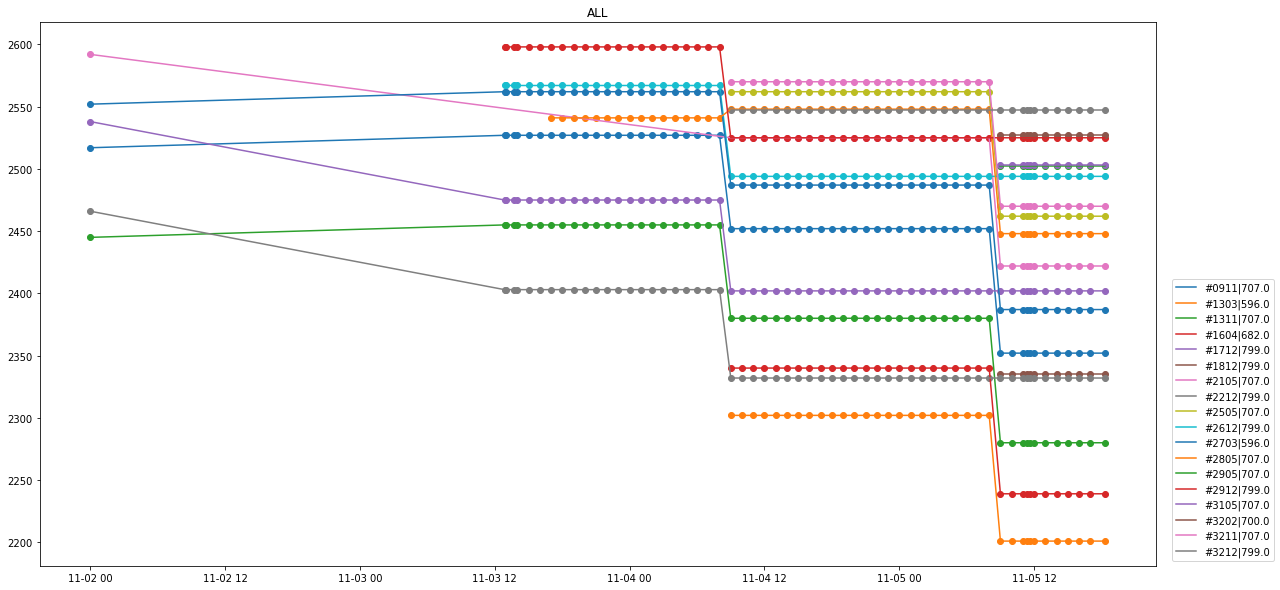

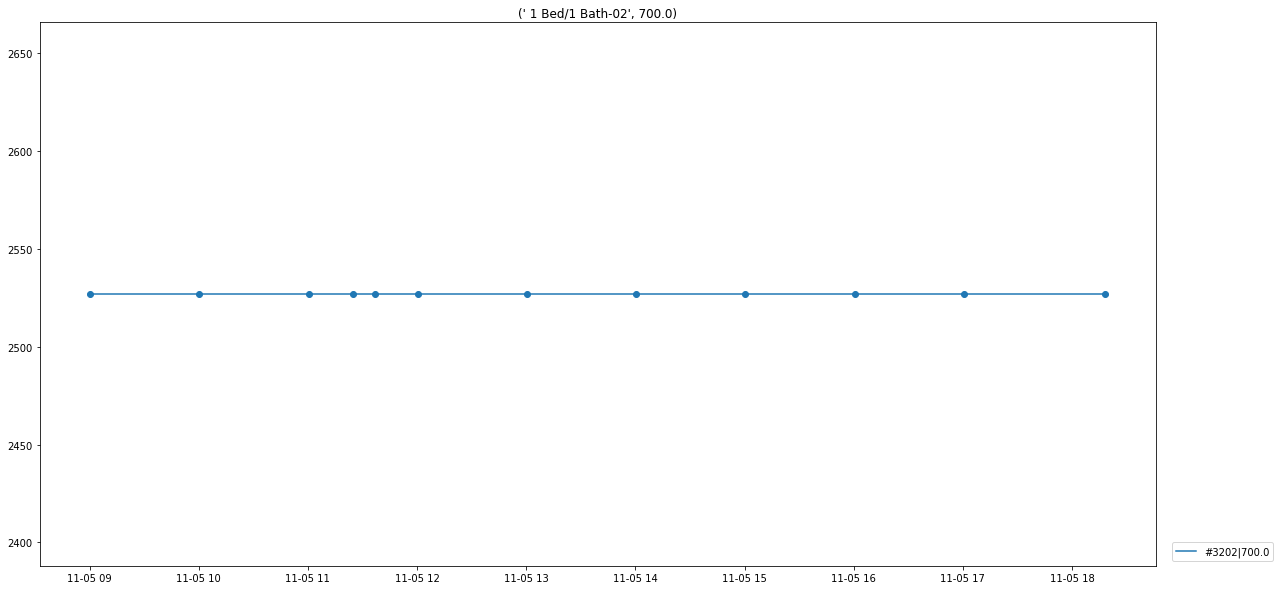

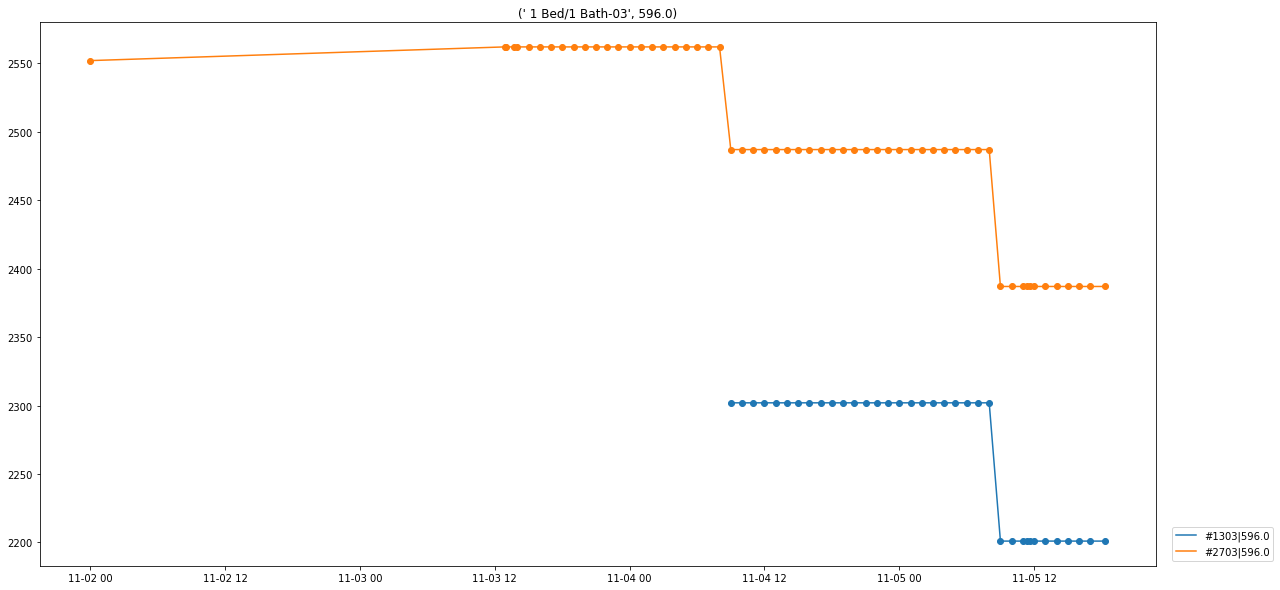

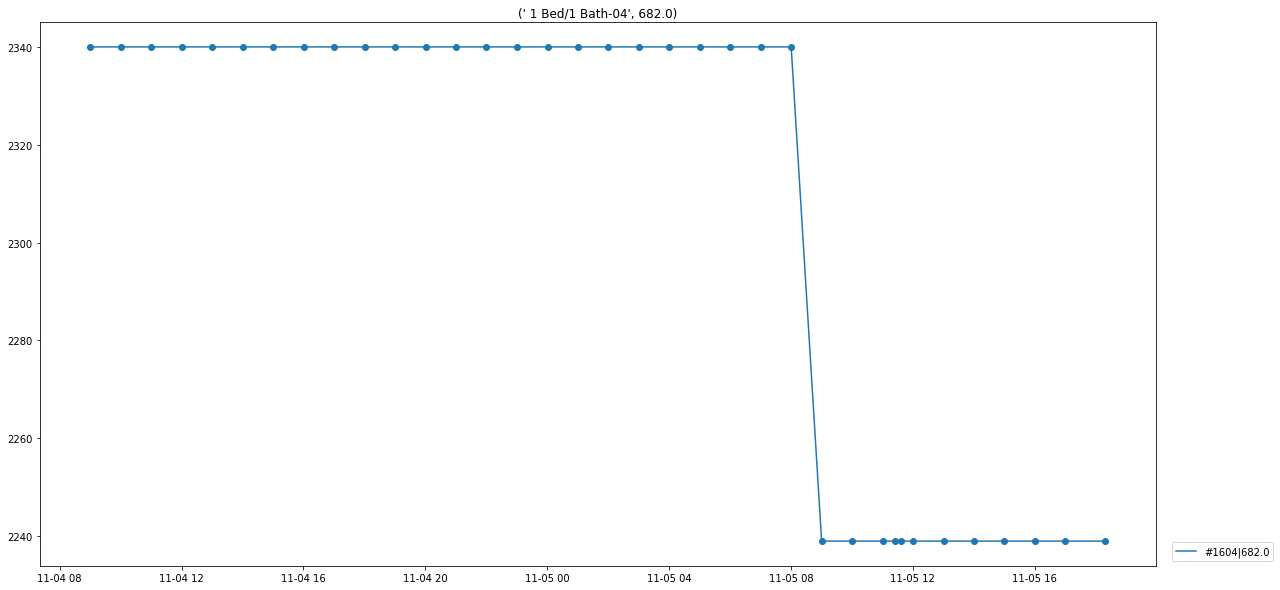

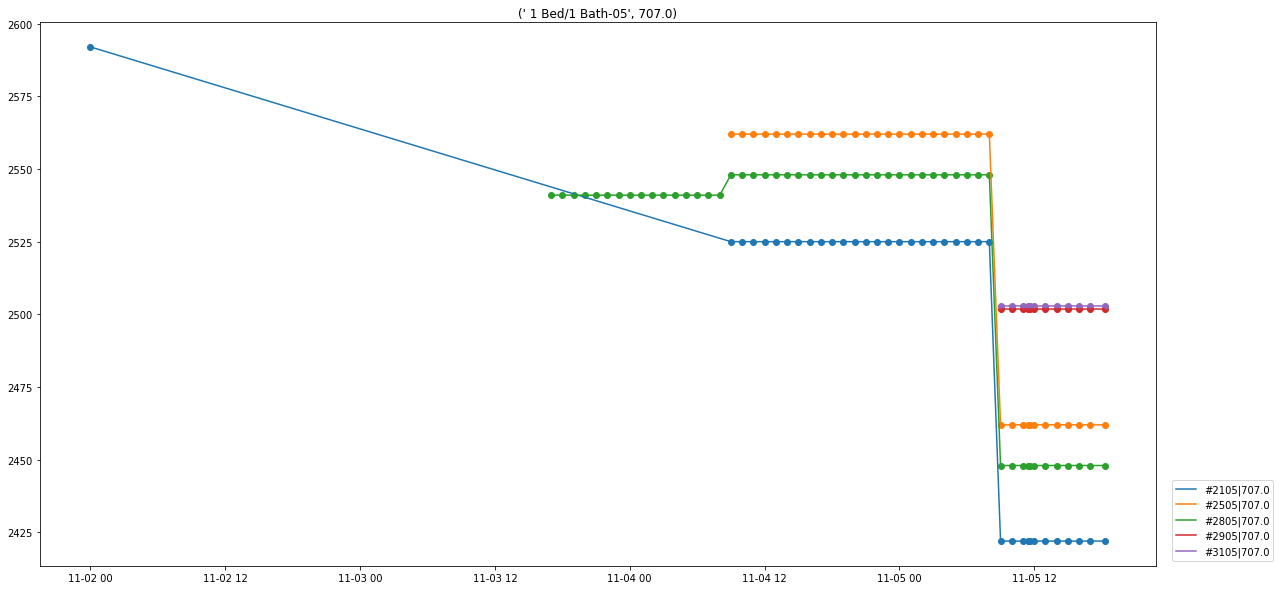

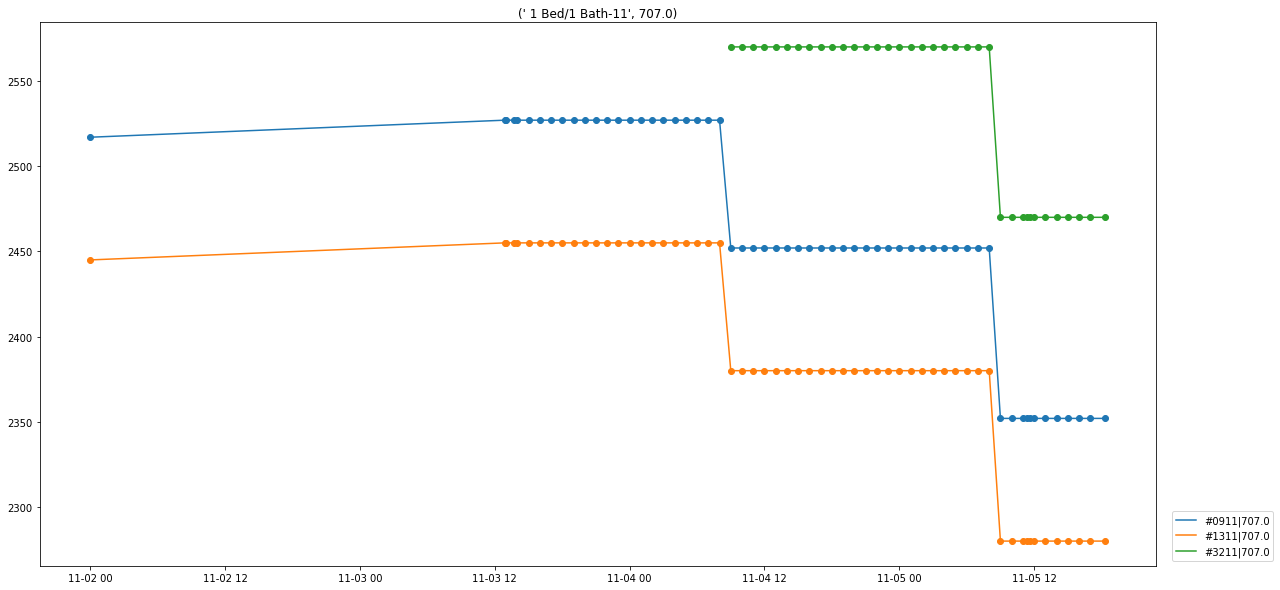

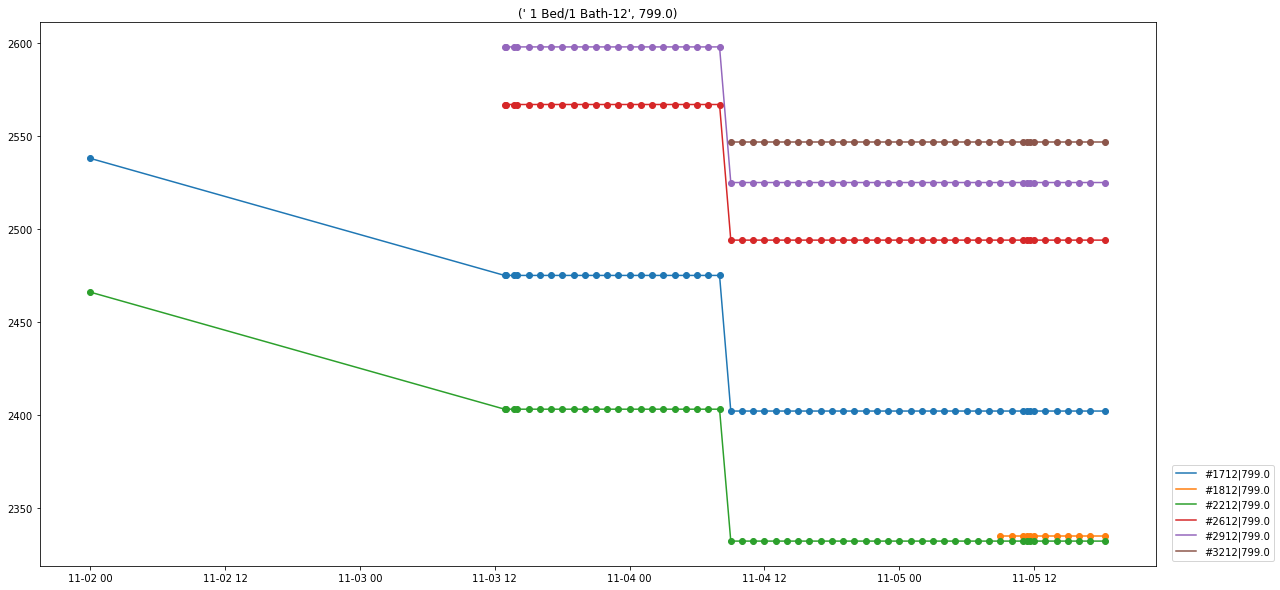

In [196]:
df_plot = df.query('num_bedroom == 1 and num_bathroom == 1 and price_floor < 2600 and `Sq.Ft` <'
                   '= 799')#.sort_values('price_floor',ascending=False)
###
df_plot.date_update = pd.DatetimeIndex(df_plot.date_update)
show_history(df_plot,'ALL','price_sqft')
show_history(df_plot,'ALL')
for Floor_Plan,df_floor_group in df_plot.groupby(['Floor_Plan','Sq.Ft']):
    show_history(df_floor_group,Floor_Plan)